In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import feature.scrna_dataset as scrna_dataset
import model.sdes as sdes
import model.generate as generate
import model.scrna_ae as scrna_ae
import model.util as model_util
import analysis.fid as fid
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
import h5py

In [2]:
# Plotting defaults
font_list = font_manager.findSystemFonts(fontpaths=["/gstore/home/tsenga5/modules/fonts"])
for font in font_list:
    font_manager.fontManager.addfont(font)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "font.size": 13,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
latent_space = False
latent_dim = 200

In [5]:
data_file = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/scrna/covid_flu/processed/covid_flu_processed_reduced_genes.h5"
autoencoder_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/scrna_vaes/covid_flu/covid_flu_processed_reduced_genes_ldvae_d%d/" % latent_dim

models_base_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/scrna_covid_flu_continuous_class_extension"

In [6]:
branched_before_model_path = os.path.join(models_base_path, "scrna_covid_flu_continuous_branched_2classes/1/last_ckpt.pth")
branched_after_model_path = os.path.join(models_base_path, "extension/1/last_ckpt.pth")
label_guided_before_model_path = os.path.join(models_base_path, "scrna_covid_flu_continuous_labelguided_2classes/1/last_ckpt.pth")
label_guided_afterone_model_path = os.path.join(models_base_path, "extension/2/last_ckpt.pth")
label_guided_afterall_model_path = os.path.join(models_base_path, "extension/4/last_ckpt.pth")

In [7]:
# Define the branches
classes_01 = [0, 1]
branch_defs_01 = [((0, 1), 0.5795795795795796, 1), ((0,), 0, 0.5795795795795796), ((1,), 0, 0.5795795795795796)]

classes_012 = [0, 1, 5]
branch_defs_012 = [((0, 1, 5), 6.786786786786787e-01, 1), ((0, 1), 0.5795795795795796, 0.6786786786786787), ((5,), 0, 0.6786786786786787), ((0,), 0, 0.5795795795795796), ((1,), 0, 0.5795795795795796)]

classes_2 = [5]
branch_defs_2 = [((5,), 0, 0.6786786786786787)]

In [8]:
out_path = "/gstore/home/tsenga5/branched_diffusion/figures/scrna_covid_flu_class_extension"

os.makedirs(out_path, exist_ok=True)

### Create data loaders

In [9]:
dataset_01 = scrna_dataset.SingleCellDataset(data_file, autoencoder_path=(autoencoder_path if latent_space else None))
dataset_012 = scrna_dataset.SingleCellDataset(data_file, autoencoder_path=(autoencoder_path if latent_space else None))
dataset_2 = scrna_dataset.SingleCellDataset(data_file, autoencoder_path=(autoencoder_path if latent_space else None))

# Limit classes
inds_01 = np.isin(dataset_01.cell_cluster, classes_01)
dataset_01.data = dataset_01.data[inds_01]
dataset_01.cell_cluster = dataset_01.cell_cluster[inds_01]
inds_012 = np.isin(dataset_012.cell_cluster, classes_012)
dataset_012.data = dataset_012.data[inds_012]
dataset_012.cell_cluster = dataset_012.cell_cluster[inds_012]
inds_2 = np.isin(dataset_2.cell_cluster, classes_2)
dataset_2.data = dataset_2.data[inds_2]
dataset_2.cell_cluster = dataset_2.cell_cluster[inds_2]

data_loader_01 = torch.utils.data.DataLoader(dataset_01, batch_size=128, shuffle=True, num_workers=0)
data_loader_012 = torch.utils.data.DataLoader(dataset_012, batch_size=128, shuffle=True, num_workers=0)
data_loader_2 = torch.utils.data.DataLoader(dataset_2, batch_size=128, shuffle=True, num_workers=0)
input_shape = next(iter(data_loader_01))[0].shape[1:]

In [10]:
sde = sdes.VariancePreservingSDE(0.1, 5, input_shape)
t_limit = 1

In [11]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t, branch_defs):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t, branch_defs):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i, branch_defs) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

def class_to_class_index_tensor(c, classes):
    """
    Given a tensor of classes, return the corresponding class indices
    as a tensor.
    """
    return torch.argmax(
        (c[:, None] == torch.tensor(classes, device=c.device)).int(), dim=1
    ).to(DEVICE)

### Import models

In [12]:
branched_before_model = model_util.load_model(
    scrna_ae.MultitaskResNet, branched_before_model_path
).to(DEVICE)
branched_after_model = model_util.load_model(
    scrna_ae.MultitaskResNet, branched_after_model_path
).to(DEVICE)

label_guided_before_model = model_util.load_model(
    scrna_ae.LabelGuidedResNet, label_guided_before_model_path
).to(DEVICE)
label_guided_afterone_model = model_util.load_model(
    scrna_ae.LabelGuidedResNet, label_guided_afterone_model_path
).to(DEVICE)
label_guided_afterall_model = model_util.load_model(
    scrna_ae.LabelGuidedResNet, label_guided_afterall_model_path
).to(DEVICE)

### Introducing a new digit class

**Fine-tune new branch on branched model**

In [13]:
# Samples before fine-tuning
branched_before_samples = {}
for class_to_sample in classes_01:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_branched_samples(
        branched_before_model, sde, class_to_sample,
        lambda c, t: class_time_to_branch_tensor(c, t, branch_defs_01),
        sampler="pc", t_limit=t_limit, num_samples=1000, verbose=True
    ).cpu().numpy()
    branched_before_samples[class_to_sample] = samples

Sampling class: 0


100%|██████████████████████████████████████████████████████| 500/500 [00:58<00:00,  8.54it/s]


Sampling class: 1


100%|██████████████████████████████████████████████████████| 500/500 [00:58<00:00,  8.57it/s]


In [14]:
# Samples after fine-tuning
branched_after_samples = {}
for class_to_sample in classes_012:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_branched_samples(
        branched_after_model, sde, class_to_sample,
        lambda c, t: class_time_to_branch_tensor(c, t, branch_defs_012),
        sampler="pc", t_limit=t_limit, num_samples=1000, verbose=True
    ).cpu().numpy()
    branched_after_samples[class_to_sample] = samples

Sampling class: 0


100%|██████████████████████████████████████████████████████| 500/500 [00:58<00:00,  8.55it/s]


Sampling class: 1


100%|██████████████████████████████████████████████████████| 500/500 [00:58<00:00,  8.56it/s]


Sampling class: 5


100%|██████████████████████████████████████████████████████| 500/500 [00:58<00:00,  8.57it/s]


#### Train additional digit on label-guided (linear) model

In [15]:
label_guided_before_samples = {}
for class_to_sample in classes_012:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_label_guided_samples(
        label_guided_before_model, sde, class_to_sample,
        lambda c: class_to_class_index_tensor(c, classes_012),
        sampler="pc", t_limit=t_limit, num_samples=1000, verbose=True
    ).cpu().numpy()
    label_guided_before_samples[class_to_sample] = samples

Sampling class: 0


100%|██████████████████████████████████████████████████████| 500/500 [00:57<00:00,  8.71it/s]


Sampling class: 1


100%|██████████████████████████████████████████████████████| 500/500 [00:57<00:00,  8.71it/s]


Sampling class: 5


100%|██████████████████████████████████████████████████████| 500/500 [00:57<00:00,  8.71it/s]


In [16]:
label_guided_afterone_samples = {}
for class_to_sample in classes_012:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_label_guided_samples(
        label_guided_afterone_model, sde, class_to_sample,
        lambda c: class_to_class_index_tensor(c, classes_012),
        sampler="pc", t_limit=t_limit, num_samples=1000, verbose=True
    ).cpu().numpy()
    label_guided_afterone_samples[class_to_sample] = samples

Sampling class: 0


100%|██████████████████████████████████████████████████████| 500/500 [00:57<00:00,  8.74it/s]


Sampling class: 1


100%|██████████████████████████████████████████████████████| 500/500 [00:57<00:00,  8.73it/s]


Sampling class: 5


100%|██████████████████████████████████████████████████████| 500/500 [00:57<00:00,  8.73it/s]


In [17]:
label_guided_afterall_samples = {}
for class_to_sample in classes_012:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_label_guided_samples(
        label_guided_afterall_model, sde, class_to_sample,
        lambda c: class_to_class_index_tensor(c, classes_012),
        sampler="pc", t_limit=t_limit, num_samples=1000, verbose=True
    ).cpu().numpy()
    label_guided_afterall_samples[class_to_sample] = samples

Sampling class: 0


100%|██████████████████████████████████████████████████████| 500/500 [00:57<00:00,  8.73it/s]


Sampling class: 1


100%|██████████████████████████████████████████████████████| 500/500 [00:57<00:00,  8.72it/s]


Sampling class: 5


100%|██████████████████████████████████████████████████████| 500/500 [00:57<00:00,  8.72it/s]


**Compare FIDs**

In [18]:
# Sample objects from the original dataset
true_samples = {}
for class_to_sample in classes_012:
    print("Sampling class: %s" % class_to_sample)
    inds = np.where(dataset_012.cell_cluster == class_to_sample)[0]
    sample_inds = np.random.choice(inds, size=1000, replace=False)
    true_samples[class_to_sample] = dataset_012.data[sample_inds]

Sampling class: 0
Sampling class: 1
Sampling class: 5


In [19]:
if not latent_space:
    dataset_with_ae = scrna_dataset.SingleCellDataset(data_file, autoencoder_path=autoencoder_path)

def compute_fid(gen_samples, true_samples, latent=True):
    if latent_space:
        if latent:
            return fid.compute_fid(
                gen_samples,
                dataset_01.encode_batch(torch.tensor(true_samples, device=DEVICE)).cpu().numpy()
            )
        else:
            return fid.compute_fid(
                dataset_01.decode_batch(torch.tensor(gen_samples, device=DEVICE)).cpu().numpy(),
                true_samples
            )
    else:
        gen_samples[gen_samples < 0] = 0  # Generated values should never be above 0
        if latent:
            return fid.compute_fid(
                dataset_with_ae.encode_batch(torch.tensor(gen_samples, device=DEVICE)).cpu().numpy(),
                dataset_with_ae.encode_batch(torch.tensor(true_samples, device=DEVICE)).cpu().numpy()
            )
        else:
            return fid.compute_fid(
                dataset_with_ae.decode_batch(dataset_with_ae.encode_batch(torch.tensor(gen_samples, device=DEVICE))).cpu().numpy(),
                dataset_with_ae.decode_batch(dataset_with_ae.encode_batch(torch.tensor(true_samples, device=DEVICE))).cpu().numpy()
            )

[rank: 0] Global seed set to 0


INFO     File                                                                                                      
         /gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/scrna_vaes/covid_flu/covid_flu_proc
         essed_reduced_genes_ldvae_d200/model.pt already downloaded                                                


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/gstore/home/tsenga5/miniconda3/envs/scanpy/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [20]:
branched_before_fids = {}
branched_after_fids = {}
label_guided_before_fids = {}
label_guided_afterone_fids = {}
label_guided_afterall_fids = {}

latent = True

for c in branched_before_samples.keys():
    branched_before_fids[c] = compute_fid(branched_before_samples[c], true_samples[c], latent)
for c in branched_after_samples.keys():
    branched_after_fids[c] = compute_fid(branched_after_samples[c], true_samples[c], latent)
for c in label_guided_before_samples.keys():
    label_guided_before_fids[c] = compute_fid(label_guided_before_samples[c], true_samples[c], latent)
for c in label_guided_afterone_samples.keys():
    label_guided_afterone_fids[c] = compute_fid(label_guided_afterone_samples[c], true_samples[c], latent)
for c in label_guided_afterall_samples.keys():
    label_guided_afterall_fids[c] = compute_fid(label_guided_afterall_samples[c], true_samples[c], latent)

In [21]:
print(branched_before_fids)
print(branched_after_fids)
print(label_guided_before_fids)
print(label_guided_afterone_fids)
print(label_guided_afterall_fids)

{0: 17.2739535824701, 1: 20.49201217272837}
{0: 17.949118294077465, 1: 20.02476075887448, 5: 23.667188069263155}
{0: 20.895702081753146, 1: 21.95368448451966, 5: 27.22452015744281}
{0: 24.710472874965525, 1: 27.29852642512873, 5: 31.712231368373526}
{0: 18.359188765377848, 1: 20.05407637633136, 5: 27.03074935550749}


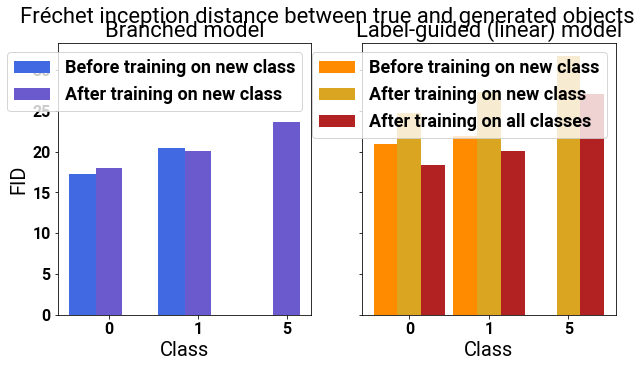

In [22]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))

bar_width = 0.3
x = np.arange(len(branched_after_fids))

branched_before_vals = [branched_before_fids[c] for c in classes_01] + [0]
branched_after_vals = [branched_after_fids[c] for c in classes_012]
ax[0].bar(
    x, branched_before_vals, bar_width, label="Before training on new class", color="royalblue"
)
ax[0].bar(
    x + bar_width, branched_after_vals, bar_width, label="After training on new class", color="slateblue"
)
ax[0].set_title("Branched model")

label_guided_before_vals = [label_guided_before_fids[c] for c in classes_01] + [0]
label_guided_afterone_vals = [label_guided_afterone_fids[c] for c in classes_012]
label_guided_afterall_vals = [label_guided_afterall_fids[c] for c in classes_012]
ax[1].bar(
    x, label_guided_before_vals, bar_width, label="Before training on new class", color="darkorange"
)
ax[1].bar(
    x + bar_width, label_guided_afterone_vals, bar_width, label="After training on new class", color="goldenrod"
)
ax[1].bar(
    x + (2 * bar_width), label_guided_afterall_vals, bar_width, label="After training on all classes", color="firebrick"
)
ax[1].set_title("Label-guided (linear) model")
for i in range(2):
    ax[i].set_xticks(x + bar_width, labels=[c for c in classes_012])
    ax[i].set_xlabel("Class")
    ax[i].legend()
ax[0].set_ylabel("FID")
fig.suptitle("Fréchet inception distance between true and generated objects")
fig.savefig(
    os.path.join(out_path, "scrna_class_extension_fid.svg"),
    format="svg"
)
plt.show()